<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-обзору-данных" data-toc-modified-id="Вывод-по-обзору-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод по обзору данных</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Логистичеческая-регрессия." data-toc-modified-id="Логистичеческая-регрессия.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Логистичеческая регрессия.</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Проверка-результатов-работы-на-тестовой-выборке:" data-toc-modified-id="Проверка-результатов-работы-на-тестовой-выборке:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка результатов работы на тестовой выборке:</a></span><ul class="toc-item"><li><span><a href="#Итоговый-вывод:" data-toc-modified-id="Итоговый-вывод:-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Итоговый вывод:</a></span></li></ul></li></ul></div>

# Проект для «Викишоп» с BERT

В качестве дополнительных материалов к проекту, кроме материалов спринта использовались:

   - 1. BERT, ELMO и Ко в картинках (как в NLP пришло трансферное обучение) - https://habr.com/ru/post/487358/
    
   - 2. Word2vec в картинках - https://habr.com/ru/post/446530/
   
   - 3. Ваш первый BERT: иллюстрированное руководство - https://habr.com/ru/post/498144/
    

## Описание данных

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель проекта:**

Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Необходимо построить модель со значением метрики качества F1 не меньше 0.75.

**План работ:**

- 1. Подготовка данных
    - Откроем данные и изучим их.
    - Предобработаем текст по рекомендациям спринта
    - Создадим новую таблицу признаков инструментариями предобученной модели Bert.
    
- 2. Обучим несколько разных моделей на подготовленных данных. Для каждой попробуем найти оптимальные гиперпараметры.
    
- 3. Проанализируем качество моделей.
    
- 4. Сформулируем итоговый вывод.

## Обзор данных

In [1]:
# ячейка для загрузки библиотек, служебных команд и функций
import numpy as np
import os
import pandas as pd
import re
import warnings

import torch
import transformers

from tqdm import notebook
from tqdm import tqdm

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

warnings.simplefilter(action='ignore')

In [66]:
# Считаем наши данные
pth_1 = 'toxic_comments.csv'  # Локальный путь
pth_2 = '/datasets/toxic_comments.csv'  # Серверный путь

if os.path.exists(pth_1):
    data = pd.read_csv(pth_1)
elif os.path.exists(pth_2):
    data = pd.read_csv(pth_2)
else:
    print('Something is wrong')

In [67]:
data.sample(11)

,text,toxic
87813,You gotta love when they send a noted racist a...,1
110286,Targeted Proximity Operations \n\nIt is also n...,0
15363,Thank you for experimenting with Wikipedia. Yo...,0
151222,I.............. \n\nI Just Want to say you are...,0
30556,"""\n\nMathematical Chemistry, Theoretical Chemi...",0
121298,The flaws? What flaws? This is exactly the cru...,0
102625,"Sorry, one more canon question. Was her boyfr...",0
75281,"Deathcore band, not Death Metal",0
130786,Help me \n\nMy autism is acting up. I'm about ...,0
23547,"""\n\nTo quote the article: It was once known a...",0


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [69]:
data.duplicated().sum()

0

Посмотрим на целевой признак:

0    0.898321
1    0.101679
Name: toxic, dtype: float64

<AxesSubplot:>

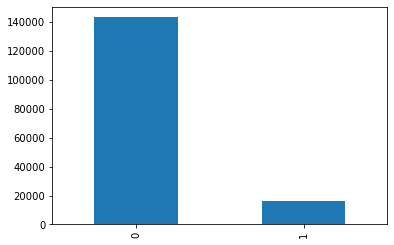

In [70]:
display(data.toxic.value_counts(normalize=True))
data.toxic.value_counts().plot(kind='bar')

Явный дисбаланс классов. Это надо будет учитывать в нашей задаче классификации.

### Вывод по обзору данных

159571 запись. Нет пропусков и дубликатов. Текст нужно предобработать на наличие лишних символов, заглавных букв и прочее. Необходимо учитывать, что целевой признак находится в дисбалансе в отношении 90%:10%. Данные пригодны для предобработки.

## Предобработка данных

Создадим функцию по очистке текста от лишних символов и приведению его к одному регистру:

In [71]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text).lower()
    return " ".join(text.split())

In [72]:
#Создадим копию наших данных, чтоб всегда иметь неизменные данные. Дальше будем работать с копией
comments = data.copy()

In [75]:
tqdm.pandas()
comments['text'] = comments.text.progress_apply(clear_text)

100%|███████████████████████████████████████████████████████████████████████| 159571/159571 [00:03<00:00, 51938.75it/s]


In [76]:
comments.sample(11)

,text,toxic
135411,linkin park ah so you wannna say that hybrid t...,0
35649,i added a comment made by one of the editors i...,0
114083,but the is minor but it affect the whole page ...,0
134653,i must note that the golden sun page was made ...,0
94923,how is it pointless its engaging a social conv...,0
61070,it s unlikely that the cnn article can be cons...,0
80645,i just meant that it seems like an official en...,0
21100,i ve drawn on that along with his blue book bi...,0
19291,see talk chester f c thanks,0
106198,mathew matthew david white is a very important...,0


после приведения могут быть дупликаты, посмотрим:

In [77]:
comments.duplicated().sum()

1293

Посмотрим:

In [78]:
comments[comments.duplicated(keep=False)].sort_values(by='text')

,text,toxic
4482,,0
53787,,0
61758,,0
17311,,0
82681,,0
...,...,...
144543,your request to be unblocked has been granted ...,0
131761,your stalker friend is back the hostile user y...,0
10221,your stalker friend is back the hostile user y...,0
94591,zionist jew please stop spreadin your lies bia...,1


Ну это явные дубликаты, дроп:

In [79]:
comments.drop_duplicates(inplace=True)
comments.duplicated().sum()

0

In [80]:
comments.sort_values(by='text').head(11)

,text,toxic
4482,,0
27970,a according to wikipedia naming conventions th...,0
133363,a an we generally don t change between british...,0
36083,a and c the layout and image choice in a appea...,0
32780,a back up mr truesilver cabal don t know what ...,0
15864,a backup of a bit i deleted i thought it was r...,0
9760,a bad block which should be rescinded whowatch...,0
104963,a ballast house is where they keep the stones ...,0
7151,a ban for kontoreg eh it was merely a matter o...,0
157521,a barangay filipino baranggay is the smallest ...,0


Вроде все ровно, пустой текст мог образоваться из комментариев из одних символов, например: !!!!!. Так что пусть его модель считает нейтральной, хотя символами наверняка можно нарисовать какую-нибудь похабщину.

In [81]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158278 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    158278 non-null  object
 1   toxic   158278 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [82]:
comments.toxic.value_counts()

0    142175
1     16103
Name: toxic, dtype: int64

Для экономии ресурсов, сократим нашу базу заодно постараемся учесть баланс классов целевого признака. Возьмем по 7500 записей с обоими целевыми признаками.

In [85]:
comments_lightweighted, temp = train_test_split(comments, train_size=15000, random_state=2307,
                                                stratify=comments.toxic)
comments_lightweighted.reset_index(inplace=True, drop=True)

In [86]:
display(comments_lightweighted.head(11))
comments_lightweighted.info()

,text,toxic
0,i propose starting an article called nbn for b...,0
1,then please refrain from making unfounded accu...,0
2,a pair of twins you write a pair of twins twin...,1
3,is it the subtle idiosyncrasies of the microso...,0
4,though i do know and it can be clearly seen on...,0
5,portland next time please be careful about the...,0
6,could you please quote the section a whole par...,0
7,actually the winner of the dallas vs seattle g...,0
8,anushirvan khampalak is just hurted that he is...,1
9,forthcoming book a trio of lds scholars have b...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15000 non-null  object
 1   toxic   15000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.5+ KB


In [87]:
comments_lightweighted.toxic.value_counts(normalize=True)

0    0.898267
1    0.101733
Name: toxic, dtype: float64

Начнём работать с берт. Загружаем предварительно обученную модель BERT.

In [89]:
tokenizer = transformers.AutoTokenizer.from_pretrained("unitary/toxic-bert")

model = transformers.AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

Токенизруем текст: разбиваем его на слова в удобный формат для модели Берт.

Время выполнения ячейки ниже: ~5 сек, было 30 на старом берте

In [90]:
%%time
tokenized = comments_lightweighted.text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True,
                                                                        max_length=512, truncation=True)))
#выпадали варнинги, по их рекомендациям добавил два настроечных параметра: max_length=512, truncation=True

CPU times: total: 5.69 s
Wall time: 5.24 s


Применим метод padding, чтобы после токенизации длины исходных текстов в датафрейме были равными. Только при таком условии будет работать модель BERT. Пусть стандартной длиной вектора n будет длина наибольшего во всём датасете вектора. Остальные векторы дополним нулями:

In [91]:
%%time
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

CPU times: total: 906 ms
Wall time: 907 ms


(15000, 512)

In [98]:
padded.shape

(15000, 512)

Теперь поясним модели, что нули не несут значимой информации. Это нужно для компоненты модели, которая называется «внимание» (англ. attention).
Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения:

In [92]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(15000, 512)

In [95]:
token_dict = tokenizer.batch_encode_plus(comments_lightweighted.text.to_list()[:10], 
                                         padding=True, 
                                         max_length=512,
                                         return_attention_mask=True,
                                         truncation=True,
                                         return_tensors='pt')
type(token_dict)

transformers.tokenization_utils_base.BatchEncoding

Начнём преобразование текстов в эмбеддинги:

In [36]:
feats = pd.read_csv('features_new.csv')
targs = pd.read_csv('target_new.csv')

In [37]:
feats.head()

,0,1,2,3,4,5
0,-7.228639,-9.082730,-8.652795,-8.920074,-8.617583,-8.890891
1,-4.858508,-9.359257,-7.821092,-8.675237,-7.725113,-8.597935
2,1.929142,-5.861736,-2.533387,-6.828632,0.346626,-4.317956
3,-6.994448,-9.158156,-8.629813,-8.964745,-8.584523,-8.866958
4,-7.318407,-9.056867,-8.622766,-8.985188,-8.657290,-8.911773


In [38]:
display(feats.shape)
targs.shape

(15000, 6)

(15000, 1)

Можем приступать к обучению моделей.

## Обучение моделей

Целевым признаком у нас является столбец `toxic`, в нем отражен факт токсичности коммнтария. Эта информация является категориальной с двумя значениями, поэтому нам необходимо решить задачу бинарной классификации

Проверим следующие модели машинного обучения для задач бинарной классификации:


`Логистическая регрессия`

`Случайный лес`

`LGBMClassifier`

Для каждой модели (по возможности), будем подбирать такие гиперпараметры, которые дадут большую точность на кросс-валидации глубиною 3.

Для подсчёта метрики f1 для каждой модели напишем функцию. Дополнительно, для себя посчитаем ещё 'accuracy', 'precision' и 'recall'. Напомним:

- `accuracy` — это доля правильных ответов алгоритма
- `precision` — это доля объектов, названных классификатором положительными и при этом действительно являющимися положительными
- `recall` — это доля объектов положительного класса, правильно определенного алгоритмом, из всех объектов положительного класса.
- `f1` — это среднее гармоническое величин `precision` и `recall`

In [39]:
def score_dataset(X, y, model):
    """
    Возвращает кортеж оценок (accuracy, precision, recall, f1)
    из модели model и указанных обучающих и валидационных выборок
    """
    preds = model.predict(X)
    return(accuracy_score(y, preds),
           precision_score(y, preds),
           recall_score(y, preds),
           f1_score(y, preds))    

In [40]:
#зафиксируем параметр псевдослучайности для всех разделений и моделей.
RND_ST = 9998

In [41]:
X_train, X_test, y_train, y_test = train_test_split(feats, targs, test_size=0.25, random_state=RND_ST, stratify=targs)

### Логистичеческая регрессия.

In [42]:
parameters = {'solver': ['saga'],
              'penalty': ['none'],
              'C': np.linspace(8, 9, 1),
              'intercept_scaling': np.linspace(0.6, 0.7, 1)}

In [43]:
%%time
model_lr = LogisticRegression(random_state=RND_ST, class_weight='balanced')
random_search = RandomizedSearchCV(model_lr, param_distributions=parameters, n_jobs=-1,
                                   scoring='f1', cv=3,
                                   n_iter=1, verbose=0)  # без рандом_стейта, чтоб прогонял всешда по разным выборкам
random_search.fit(X_train, y_train)
model_final_l = random_search.best_estimator_

print(f'Метрика f1 на обучающей выборке: {random_search.best_score_:0.4}')
print(f'Параметры лучшей модели: {model_final_l}')

Метрика f1 на обучающей выборке: 0.871
Параметры лучшей модели: LogisticRegression(C=8.0, class_weight='balanced', intercept_scaling=0.6,
                   penalty='none', random_state=9998, solver='saga')
CPU times: total: 234 ms
Wall time: 3.1 s


Довльно неплохой результат! Целевая метрика F1 на выборке с кросс-валидацией=3 дала значение в 0.871.

In [44]:
results = pd.DataFrame({'f1_train (cv=3)': [0.871]}, index=['logistic_regression'])
display(results)

,f1_train (cv=3)
logistic_regression,0.871


### Случайный лес

In [45]:
parameters = {'n_estimators': np.arange(124, 125, 10),
                  'max_depth': np.arange(27, 28, 10),
                  'min_samples_split': np.arange(2, 3, 2),
                  'max_features': ['sqrt'],
                  'criterion': ['entropy'],
                  'min_samples_leaf': np.arange(1, 2, 2),
                  'bootstrap': [True]}

In [46]:
%%time
model_r = RandomForestClassifier(random_state=RND_ST, class_weight='balanced')
random_search = RandomizedSearchCV(model_r, param_distributions=parameters, n_jobs=-1,
                                   scoring='f1', cv=3,
                                   n_iter=1, verbose=0)  # без рандом_стейта, чтоб прогонял всешда по разным выборкам
random_search.fit(X_train, y_train)
model_final_r = random_search.best_estimator_

print(f'Метрика f1 на обучающей выборке: {random_search.best_score_:0.4}')
print(f'Параметры лучшей модели: {model_final_r}')

Метрика f1 на обучающей выборке: 0.9051
Параметры лучшей модели: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=27, max_features='sqrt', n_estimators=124,
                       random_state=9998)
CPU times: total: 1.89 s
Wall time: 4.23 s


In [47]:
results.loc['RandomForestClassifier'] = [0.9051]
results.sort_values(by='f1_train (cv=3)', ascending=False)

,f1_train (cv=3)
RandomForestClassifier,0.9051
logistic_regression,0.8710


Хуже и дольше, чем логистическая регрессия, но тоже гораздо выше требуемой метрики в 0.75!

### LGBMClassifier

In [48]:
parameters = {"learning_rate": np.arange(0.13, 0.14, 0.02),
              "max_depth": np.arange(9, 10, 2),
              "num_leaves": np.arange(162, 163, 1),
              "n_estimators": np.arange(490, 500, 10)}

In [49]:
%%time
model_lg = LGBMClassifier(random_state=RND_ST, class_weight='balanced')
random_search = RandomizedSearchCV(model_lg, param_distributions=parameters, n_jobs=-1,
                                   scoring='f1', cv=3,
                                   n_iter=1, verbose=0)
random_search.fit(X_train, y_train)
model_final_lg = random_search.best_estimator_

print(f'Метрика f1 на обучающей выборке: {random_search.best_score_:0.4}')
print(f'Параметры лучшей модели: {model_final_lg}')

Метрика f1 на обучающей выборке: 0.891
Параметры лучшей модели: LGBMClassifier(class_weight='balanced', learning_rate=0.13, max_depth=9,
               n_estimators=490, num_leaves=162, random_state=9998)
CPU times: total: 1.8 s
Wall time: 2.34 s


#это все старые комментарии

Практически такой же результат как и у логистической регрессии, разница в 0.0008! Только время работы в 7,5 раз дольше! Оставим моделью-победителем логистическую регрессию.

In [50]:
results.loc['LGBMClassifier'] = [0.891]
results.sort_values(by='f1_train (cv=3)', ascending=False)

,f1_train (cv=3)
RandomForestClassifier,0.9051
LGBMClassifier,0.8910
logistic_regression,0.8710


## Проверка результатов работы на тестовой выборке:

Показатели итоговой модели logistic_regression: accuracy=0.9685, precision=0.7683, recall=0.9895, f1=0.865
CPU times: total: 266 ms
Wall time: 77.9 ms


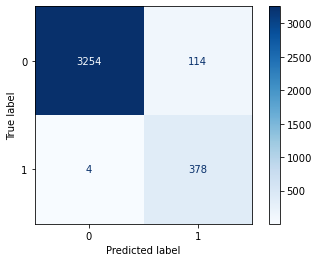

In [51]:
%%time
scores = score_dataset(X_test, y_test, model_final_l)
print(f'Показатели итоговой модели logistic_regression: accuracy={scores[0]:0.4}, precision={scores[1]:0.4}, \
recall={scores[2]:0.4}, f1={scores[3]:0.4}')
plot_confusion_matrix(model_final_l, X=X_test, y_true=y_test, normalize=None, cmap='Blues')

Логистическая регрессия дала 0.865 на тестовой выборке!

Показатели итоговой модели logistic_regression: accuracy=0.9832, precision=0.9121, recall=0.9241, f1=0.9181
CPU times: total: 188 ms
Wall time: 148 ms


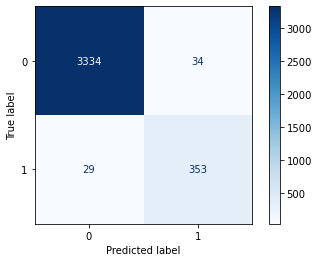

In [52]:
%%time
scores = score_dataset(X_test, y_test, model_final_r)
print(f'Показатели итоговой модели logistic_regression: accuracy={scores[0]:0.4}, precision={scores[1]:0.4}, \
recall={scores[2]:0.4}, f1={scores[3]:0.4}')
plot_confusion_matrix(model_final_r, X=X_test, y_true=y_test, normalize=None, cmap='Blues')

Показатели итоговой модели LGBMClassifier: accuracy=0.9805, precision=0.8796, recall=0.9372, f1=0.9075
CPU times: total: 562 ms
Wall time: 155 ms


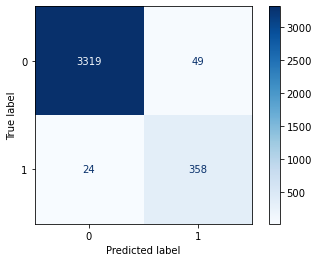

In [53]:
%%time
scores = score_dataset(X_test, y_test, model_final_lg)
print(f'Показатели итоговой модели LGBMClassifier: accuracy={scores[0]:0.4}, precision={scores[1]:0.4}, \
recall={scores[2]:0.4}, f1={scores[3]:0.4}')
plot_confusion_matrix(model_final_lg, X=X_test, y_true=y_test, normalize=None, cmap='Blues')

Отличные результаты для всех моделей на тестовой выборке. По оценке качество-скорость предпочтение лучше отдать СЛУЧАЙНОМУ ЛЕСУ!

### Итоговый вывод:

В представленных нам исходных данных содержались размеченные текстовые комментарии по признаку токсичны они или нет. Нам требовалось построить такую модель, которая может предсказывать токсичность комментариев с требуемой целевой метрикой f1 не ниже 0.75.

Для начала мы предобработали текст: удалили дубликаты, лишние символы и регистры. Далее провели векторизацию наших текстовых представлений с помощью мощнейшего инструмента BERT. С помощью предобученной модели построили новую матрицу признаков, состоящую из векторных представлений наших исходных комментариев.

Уже на новых предиктах обучили 3 модели, который все дали отличный резльтат выше требуемой метрики. Лучшей моделью по соотношению скорость-качество стала логистическая регрессия с метрикой F1 = 0.9 на тестовых данных!

✽✾✿❁❃❋❀